In [1]:
from alignment import Camera
import alignment.helper
import pickle
import json
from glob import glob
import re
from pathinference import PathInference
from pathinference.helper import confidence_ellipse
from pathinference.kernel import kernelwrap, EQ
import numpy as np

2024-07-01 12:31:09.461005: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-01 12:31:09.500057: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-01 12:31:09.500633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 12:31:10.185203: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
datapath = '/home/mike/Documents/Research/rsync_bee/test/beephotos/2024-06-20/CalibTest200624/conetag2/'

In [3]:
if datapath[-1]=='/': datapath = datapath[:-1]
calset = 'cal'
sourcename = 'btalignment'
tagsource = 'btviewer'
taglabel = ''
calsetpath = '/'.join(datapath.split('/')[:-1])+'/'+calset
keepcolour = False

In [4]:
calsetpaths = glob(calsetpath+'/*/*')

In [5]:
if not keepcolour:
    allcalimgfiles = [sorted(glob(p+'/*.np')) for p in calsetpaths]
    print("Removing colour cameras from set")
    greyscale = [alignment.helper.guesscamtypegetscore(imgfiles[0])<0.02 for imgfiles in allcalimgfiles]
    calsetpaths = [p for p,g in zip(calsetpaths,greyscale) if g]
    

Removing colour cameras from set


In [6]:
#create the camera objects from the alignment data...
cameras = {}
for path in calsetpaths:
    jsonfile = path+'/'+sourcename+'/alignment.json'
    camsetid = '/'.join(path.split('/')[-2:])
    jsondata = json.load(open(jsonfile,'r'))
    cameras[camsetid] = Camera(loc=jsondata['loc'], orientation=jsondata['orientation'], hfov=jsondata['hfov'], vfov=jsondata['vfov'], res=jsondata['res'])

In [7]:
#load the tag locations
tagsetpaths = glob(datapath+'/*/*')
tagsetpaths
if not keepcolour:
    alltagimgfiles = [sorted(glob(p+'/*.np')) for p in tagsetpaths]
    print("Removing colour cameras from set")
    greyscale = [alignment.helper.guesscamtypegetscore(imgfiles[0])<0.02 for imgfiles in alltagimgfiles]
    tagsetpaths = [p for p,g in zip(tagsetpaths,greyscale) if g]

Removing colour cameras from set


In [8]:
def totalsecsandms(st):
    time_hms = [int(s) for s in re.findall('([0-9]{1,2})[:\+]([0-9]{2})[:\+]([0-9]{2}).([0-9]{6})',st)[0]]
    return time_hms[0]*3600 + time_hms[1]*60 + time_hms[2]*1 + time_hms[3]/1e6


In [27]:
obstimes = []
observations = []

for path in tagsetpaths:
    camsetid = '/'.join(path.split('/')[-2:])
    tagsourcefiles = glob(path+'/'+tagsource+'/*.json')
    #camsetid = '/'.join(path.split('/')[-2:])
    c = cameras[camsetid]
    for fn in tagsourcefiles:
        jsondata = json.load(open(fn,'r'))
        pixelcoord = np.array([jsondata[0]['x'],jsondata[0]['y']]).astype(float)
        vect = c.get_pixel_local_vector(pixelcoord)
        obstimes.append(totalsecsandms(fn))
        observations.append(np.r_[c.loc,vect])        
    #cameras[camsetid] = Camera(loc=jsondata['loc'], orientation=jsondata['orientation'], hfov=jsondata['hfov'], vfov=jsondata['vfov'], res=jsondata['res'])
observations = np.array(observations)
obstimes = np.array(obstimes)

(array([8., 7., 8., 9., 8., 7., 9., 6., 5., 5., 5., 4., 4., 4., 2., 2., 2.,
        0., 0., 3.]),
 array([52177.986293  , 52179.13975365, 52180.2932143 , 52181.44667495,
        52182.6001356 , 52183.75359625, 52184.9070569 , 52186.06051755,
        52187.2139782 , 52188.36743885, 52189.5208995 , 52190.67436015,
        52191.8278208 , 52192.98128145, 52194.1347421 , 52195.28820275,
        52196.4416634 , 52197.59512405, 52198.7485847 , 52199.90204535,
        52201.055506  ]),
 <BarContainer object of 20 artists>)

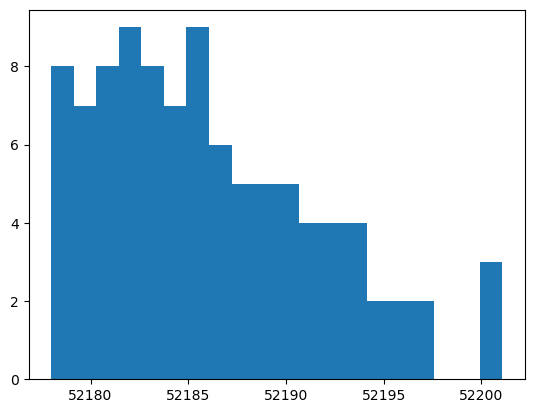

In [28]:
plt.hist(obstimes,20)

In [104]:
stds

array([15.531445  , 11.971746  ,  8.964423  ,  6.4313974 ,  4.430159  ,
        2.8714945 ,  1.7518322 ,  0.98117644,  0.5204551 ,  0.3163458 ,
        0.27000475,  0.26347372,  0.2536666 ,  0.23355159,  0.2137754 ,
        0.18646365,  0.17135319,  0.15952979,  0.15364897,  0.1500564 ,
        0.14828573,  0.14480856,  0.13946566,  0.1385518 ,  0.14436917,
        0.15157554,  0.14926237,  0.1545908 ,  0.15714033,  0.15938343,
        0.15385991,  0.15443072,  0.15681984,  0.15659533,  0.16157109,
        0.1656563 ,  0.17393334,  0.17407495,  0.17972684,  0.17883378,
        0.17948128,  0.18813676,  0.19651689,  0.19961277,  0.20812249,
        0.21023124,  0.21649224,  0.220382  ,  0.22660461,  0.23248577,
        0.2377045 ,  0.24408968,  0.24487944,  0.2420028 ,  0.23756908,
        0.23649016,  0.23488055,  0.23830569,  0.24283409,  0.2537362 ,
        0.2700741 ,  0.3074098 ,  0.3697619 ,  0.48214033,  0.6326765 ,
        0.82114166,  1.0373585 ,  1.2741439 ,  1.5177758 ,  1.75

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1.9178009 , 0.72217757, 0.2511636 ], dtype=float32)>

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.animation as animation

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)

plt.axis('equal')
#plt.plot(true_locations[:,0],true_locations[:,1],'x-')

times = Xtest.numpy()[:int(len(Xtest.numpy())/3),0]

def animate(i):
    ax.clear()
    #keep = np.where((np.array(obstimes)>i/10+52180) & (np.array(obstimes)<i/10+52180.5))
    #for obs,t in zip(observations[keep],obstimes[keep]):
    for obs,t in zip(observations,obstimes):
        anitime = (i/10+52180)
        alpha = 1-3*np.abs(t-anitime)
        
        if alpha>0:
            ax.plot([obs[0],obs[0]+obs[3]*10],[obs[1],obs[1]+obs[4]*10],color='grey',alpha=alpha)
            ax.add_patch(plt.Circle([obs[0],obs[1]],0.1,color='red'))
    
    ax.plot(M.numpy()[stds<0.25,0],M.numpy()[stds<0.25,1])            
    ax.set_xlim([-1,10])
    ax.set_ylim([-5,5])
    
    idx = np.argmin(np.abs(times-(i/10+52180)))
    pix = M[idx,:]
    #ax.add_patch(plt.Circle([pix[0],pix[1]],stds[idx],color='blue'))
    ax.add_patch(confidence_ellipse(M[idx,0:2].numpy(),C[idx,:2,:2].numpy(),ax))
        
ani = animation.FuncAnimation(fig, animate, frames=150,
                    interval=100, repeat=False)
plt.close()
# Save the animation as an animated GIF
#ani.save("simple_animation.gif", dpi=900, writer=PillowWriter(fps=0.1))
FFwriter = animation.FFMpegWriter(fps=10)
ani.save('animation.mp4', writer = FFwriter)

tf.Tensor([ 3.4312482  -0.07841293], shape=(2,), dtype=float32)
tf.Tensor([ 3.4312482  -0.07841293], shape=(2,), dtype=float32)
tf.Tensor([ 3.4542441  -0.10371239], shape=(2,), dtype=float32)
tf.Tensor([ 3.4647229  -0.11721515], shape=(2,), dtype=float32)
tf.Tensor([ 3.4835672  -0.14390033], shape=(2,), dtype=float32)
tf.Tensor([ 3.498331   -0.17054676], shape=(2,), dtype=float32)
tf.Tensor([ 3.5098653  -0.20048542], shape=(2,), dtype=float32)
tf.Tensor([ 3.5175948  -0.23071325], shape=(2,), dtype=float32)
tf.Tensor([ 3.520299   -0.24617594], shape=(2,), dtype=float32)
tf.Tensor([ 3.5233     -0.27762514], shape=(2,), dtype=float32)
tf.Tensor([ 3.5234237 -0.3101018], shape=(2,), dtype=float32)
tf.Tensor([ 3.521402   -0.34436148], shape=(2,), dtype=float32)
tf.Tensor([ 3.5175722 -0.3816409], shape=(2,), dtype=float32)
tf.Tensor([ 3.515389 -0.399508], shape=(2,), dtype=float32)
tf.Tensor([ 3.5096025  -0.43777335], shape=(2,), dtype=float32)
tf.Tensor([ 3.5029533  -0.47936305], shape=(2,),

tf.Tensor([ 2.1885977  -0.49759364], shape=(2,), dtype=float32)
tf.Tensor([ 2.1955566  -0.55234104], shape=(2,), dtype=float32)
tf.Tensor([ 2.1982455 -0.6050749], shape=(2,), dtype=float32)
tf.Tensor([ 2.1978278  -0.62920326], shape=(2,), dtype=float32)
tf.Tensor([ 2.1926186 -0.6786666], shape=(2,), dtype=float32)
tf.Tensor([ 2.18366   -0.7246959], shape=(2,), dtype=float32)
tf.Tensor([ 2.168295   -0.77024657], shape=(2,), dtype=float32)
tf.Tensor([ 2.1489391 -0.8114179], shape=(2,), dtype=float32)
tf.Tensor([ 2.1367192 -0.8309109], shape=(2,), dtype=float32)
tf.Tensor([ 2.1086066 -0.8691425], shape=(2,), dtype=float32)
tf.Tensor([ 2.075688   -0.90345544], shape=(2,), dtype=float32)
tf.Tensor([ 2.037986   -0.93535995], shape=(2,), dtype=float32)
tf.Tensor([ 1.9937925 -0.9662231], shape=(2,), dtype=float32)
tf.Tensor([ 1.9707748 -0.9800077], shape=(2,), dtype=float32)
tf.Tensor([ 1.9212373 -1.0059383], shape=(2,), dtype=float32)
tf.Tensor([ 1.865296  -1.0287066], shape=(2,), dtype=float

In [86]:
pathi = PathInference(obstimes, observations, kernelwrap(EQ,ls=3.0,scale=50), likenoisescale=0.2, Nind=20)

In [88]:
pathi.run(700,0.25)

0 [13544.404]
20 [2729.3748]
40 [669.0228]
60 [394.4963]
80 [327.4015]
100 [301.11197]
120 [302.43896]
140 [299.95453]
160 [301.28912]
180 [299.29688]
200 [299.3854]
220 [297.91315]
240 [297.9192]
260 [297.75943]
280 [297.94037]
300 [299.36713]
320 [297.95013]
340 [297.54626]
360 [300.65463]
380 [303.39334]
400 [303.4584]
420 [301.524]
440 [298.70245]
460 [297.0586]
480 [301.46786]
500 [300.9597]
520 [299.68973]
540 [300.03345]
560 [298.8337]
580 [300.5099]
600 [302.2058]
620 [301.30298]
640 [300.2707]
660 [299.2481]
680 [302.4892]


In [123]:
Xtest = pathi.buildinputmatrix(500)
M,C = pathi.getpredictions(Xtest)

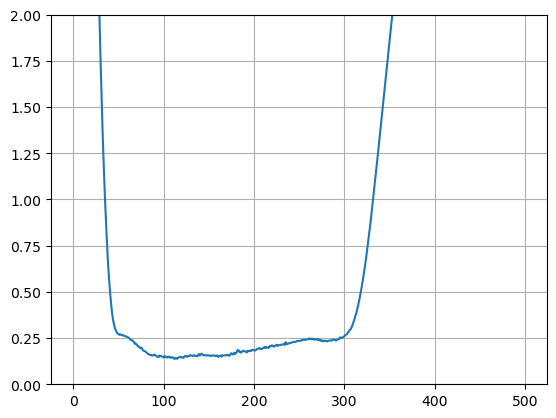

In [124]:
stds = np.sqrt(np.sum(np.array([np.diag(c) for c in C.numpy()]),1))
plt.plot(stds)
plt.ylim([0,2])
plt.grid()

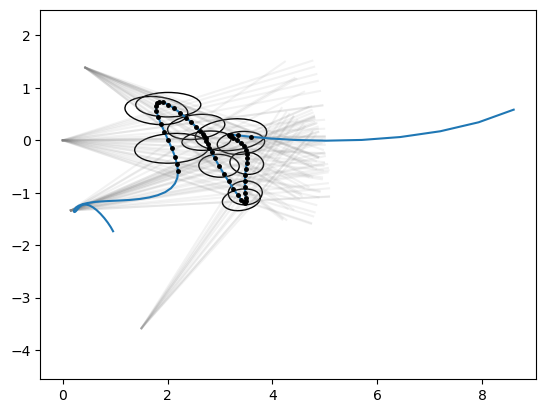

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.axis('equal')
plt.axis('equal')
for obs in observations:
    plt.plot([obs[0],obs[0]+obs[3]*5],[obs[1],obs[1]+obs[4]*5],color='grey',alpha=0.1)
plt.plot(M[:,0],M[:,1])
ax = plt.gca()
for i,(m,c) in enumerate(zip(M.numpy(),C.numpy())):
    std = max(np.sqrt(c[0,0]),np.sqrt(c[1,1]))
    if std<0.5:
        plt.plot(m[0],m[1],'.k',markersize=5)

        if i%5==0:
            el = confidence_ellipse(m[:2],c[:2,:2],ax)
            ax.add_patch(el)

plt.show()

In [71]:
std

10.804457